<a href="https://colab.research.google.com/github/DhrubaAdhikary/GEN_AI_DEMO/blob/master/Langraph_AGent_%2B_MCP_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

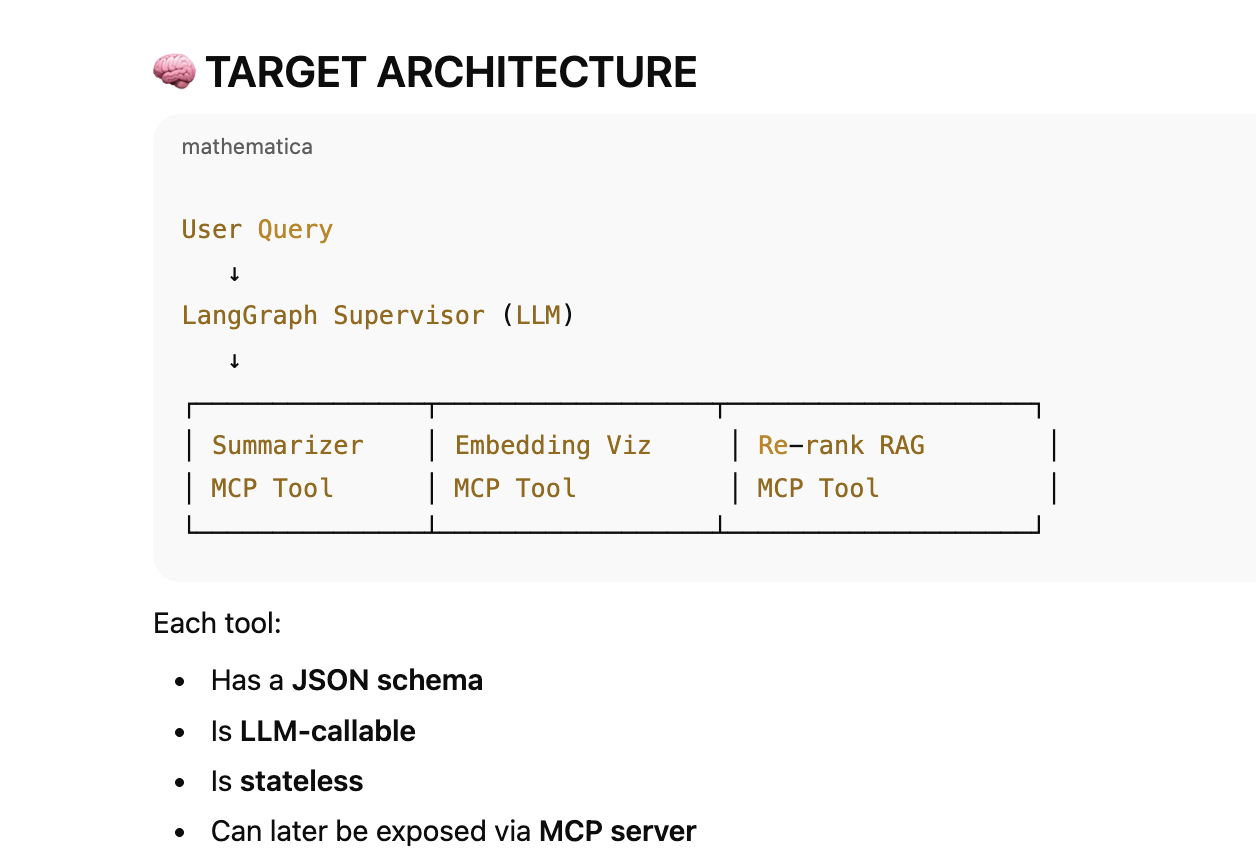

### Install Required Libraries

This cell installs all the necessary Python libraries for the project, including:
- `langgraph`: For building stateful, multi-actor applications with LLMs.
- `langchain`: A framework for developing applications powered by language models.
- `langchain-openai`: Integrates OpenAI's LLMs with LangChain.
- `openai`: The official OpenAI Python client.
- `numpy`: For numerical operations.
- `scikit-learn`: For machine learning utilities, specifically for cosine similarity.
- `umap-learn`: For Uniform Manifold Approximation and Projection for dimension reduction.
- `plotly`: For interactive data visualizations.
- `faiss-cpu`: For efficient similarity search and clustering of dense vectors.
- `sentence-transformers`: For generating sentence embeddings.
- `pypdf`: For extracting text from PDF documents.

In [1]:
!pip install -U \
  langgraph \
  langchain \
  langchain-openai \
  openai \
  numpy \
  scikit-learn \
  umap-learn \
  plotly \
  faiss-cpu \
  sentence-transformers \
  pypdf


  Using cached numpy-2.4.1-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (6.6 kB)


### Set Up OpenAI API Key

This cell prompts you to enter your OpenAI API key securely. The key is then stored as an environment variable, `OPENAI_API_KEY`, which is required for authenticating requests to OpenAI's models.

In [15]:
import os
from getpass import getpass

os.environ["OPENAI_API_KEY"] = getpass("Enter OpenAI API Key: ")


Enter OpenAI API Key: ··········


### Import Core Libraries

This cell imports essential modules:
- `numpy` for numerical computations.
- `List` and `TypedDict` from `typing` for type hints and defining structured dictionaries.
- `ChatOpenAI` from `langchain_openai` to interact with OpenAI's chat models.
- `tool` from `langchain.tools` to define custom tools callable by the language model.
- `StateGraph` and `END` from `langgraph.graph` to build and manage the stateful agent graph.

In [16]:
import numpy as np
from typing import List, TypedDict

from langchain_openai import ChatOpenAI
from langchain.tools import tool
from langgraph.graph import StateGraph, END


### Upload and Load Documents

This cell facilitates uploading documents (PDFs or text files) from your local system. It then reads the content of these documents:
- For PDF files, it uses `pypdf` to extract text from all pages.
- For other file types, it reads the content as plain text.
The extracted text from all documents is stored in the `documents` list.

In [4]:
from google.colab import files
from pypdf import PdfReader

uploaded = files.upload()

documents = []

for filename in uploaded:
    if filename.endswith(".pdf"):
        reader = PdfReader(filename)
        text = "\n".join(page.extract_text() for page in reader.pages)
    else:
        with open(filename, "r", encoding="utf-8") as f:
            text = f.read()
    documents.append(text)

print(f"Loaded {len(documents)} documents")


Saving INV-KA-B1-154009373-102017637806-NOVEMBER-2025.pdf to INV-KA-B1-154009373-102017637806-NOVEMBER-2025 (1).pdf
Loaded 1 documents


### Chunk Text Data

This cell defines a `chunk_text` function to break down large text documents into smaller, manageable chunks. This is crucial for processing text with LLMs, which often have token limits. Each chunk has a specified `size` (e.g., 500 characters) and an `overlap` (e.g., 100 characters) to maintain context between chunks.

After defining the function, it iterates through the `documents` list and applies the `chunk_text` function to each document, extending the `chunks` list with the resulting text segments.

In [5]:
def chunk_text(text, size=500, overlap=100):
    chunks = []
    start = 0
    while start < len(text):
        end = start + size
        chunks.append(text[start:end])
        start = end - overlap
    return chunks

chunks = []
for doc in documents:
    chunks.extend(chunk_text(doc))

print(f"Total chunks: {len(chunks)}")


Total chunks: 6


### Define Agent State

This cell defines the `AgentState` using `TypedDict`, which specifies the structure of the state object that will be passed between nodes in the LangGraph agent. It includes:
- `query`: The user's input query (string).
- `chunks`: A list of text chunks extracted from the documents.
- `result`: A dictionary to store the output of the agent's actions (e.g., summaries, embeddings, RAG answers).

In [17]:
class AgentState(TypedDict):
    query: str
    chunks: List[str]
    result: dict


### Summarize Documents Tool

This cell defines a tool named `summarize_documents` that takes a list of `chunks` as input. It uses OpenAI's `gpt-4o-mini` model to generate a summary for each of the first five chunks. The output is a dictionary containing a list of summaries, each associated with its original `chunk_id`.

In [18]:
from openai import OpenAI
client = OpenAI()

@tool
def summarize_documents(chunks: List[str]) -> dict:
    """
    Summarize document chunks.
    """
    summaries = []

    for i, chunk in enumerate(chunks[:5]):
        resp = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {"role": "system", "content": "Summarize the content."},
                {"role": "user", "content": chunk}
            ]
        )
        summaries.append({
            "chunk_id": i,
            "summary": resp.choices[0].message.content
        })

    return {"summaries": summaries}


### Visualize Embeddings Tool

This cell defines a tool named `visualize_embeddings` that generates and visualizes embeddings for the provided text `chunks`:
- It uses OpenAI's `text-embedding-3-small` model to create embeddings for each chunk.
- `UMAP` is then used to reduce the dimensionality of these embeddings to 3D for visualization purposes.
- `cosine_similarity` calculates the similarity between chunks.
- It identifies the top 3 most similar neighbors for each chunk to create `edges` for a graph visualization.
- The tool returns the 3D coordinates (`points`), similarity connections (`edges`), and original `texts` of the chunks.

In [19]:
import umap
from sklearn.metrics.pairwise import cosine_similarity

@tool
def visualize_embeddings(chunks: List[str]) -> dict:
    """
    Generate UMAP embeddings and similarity edges.
    """
    emb = client.embeddings.create(
        model="text-embedding-3-small",
        input=chunks
    )

    X = np.array([e.embedding for e in emb.data], dtype="float32")

    reducer = umap.UMAP(n_components=3, metric="cosine", random_state=42)
    coords = reducer.fit_transform(X)

    sim = cosine_similarity(X)

    edges = []
    for i in range(len(chunks)):
        nbrs = np.argsort(sim[i])[::-1][1:4]
        for j in nbrs:
            edges.append((i, j))

    return {
        "points": coords.tolist(),
        "edges": edges,
        "texts": chunks
    }


### Rerank and Answer Query Tool (RAG)

This cell defines the `rerank_rag_answer` tool, which implements a Retrieval-Augmented Generation (RAG) approach to answer a user's `query` using the provided `chunks`:
- It generates embeddings for all `chunks` and the `query` using OpenAI's `text-embedding-3-small` model.
- `FAISS` (Facebook AI Similarity Search) is used to efficiently search for the top 5 most relevant chunks based on cosine similarity to the query embedding.
- These top chunks form the `context` for the `gpt-4o-mini` model.
- The LLM then answers the `query` using only the provided `context`, ensuring grounded and relevant responses.
- The tool returns the `answer` and the `indices` of the evidence chunks.

In [20]:
import faiss

@tool
def rerank_rag_answer(query: str, chunks: List[str]) -> dict:
    """
    Retrieve, rerank, and answer a query.
    """
    emb = client.embeddings.create(
        model="text-embedding-3-small",
        input=chunks
    )

    X = np.array([e.embedding for e in emb.data], dtype="float32")

    q_emb = client.embeddings.create(
        model="text-embedding-3-small",
        input=[query]
    ).data[0].embedding

    q_emb = np.array(q_emb, dtype="float32")

    index = faiss.IndexFlatIP(X.shape[1])
    index.add(X)

    scores, indices = index.search(np.array([q_emb]), 5)

    context = "\n".join(chunks[i] for i in indices[0])

    resp = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": "Answer using only the context."},
            {"role": "user", "content": f"Context:\n{context}\n\nQuestion:\n{query}"}
        ]
    )

    return {
        "answer": resp.choices[0].message.content,
        "evidence": indices[0].tolist()
    }


### Supervisor Node for Routing

This cell defines the `supervisor_node` function, which acts as a router within the LangGraph agent. It examines the user's `query` to determine the appropriate action:
- If the query contains "summarize", it routes to the `summarize` tool.
- If the query contains "visualize" or "embedding", it routes to the `visualize` tool.
- Otherwise, it defaults to the `rag` tool to answer the query.

In [21]:
llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)

def supervisor_node(state: AgentState):
    q = state["query"].lower()

    if "summarize" in q:
        return {"route": "summarize"}

    if "visualize" in q or "embedding" in q:
        return {"route": "visualize"}

    return {"route": "rag"}


### Build the Agent Graph

This cell constructs the LangGraph agent:
- It initializes a `StateGraph` with the `AgentState` definition.
- It adds three nodes: `supervisor`, `summarize`, `visualize`, and `rag`, each corresponding to a specific function or tool.
- `set_entry_point("supervisor")` designates the supervisor node as the starting point for any incoming query.
- `add_conditional_edges` connects the `supervisor` node to the other nodes based on the routing logic determined by the `supervisor_node` function.
- `add_edge` connects the `summarize`, `visualize`, and `rag` nodes to `END`, signifying the completion of a task.
- Finally, `app = graph.compile()` compiles the graph into an executable agent.

In [22]:
graph = StateGraph(AgentState)

graph.add_node("supervisor", supervisor_node)

graph.add_node(
    "summarize",
    lambda s: {
        "result": summarize_documents.invoke(
            {"chunks": s["chunks"]}
        )
    }
)

graph.add_node(
    "visualize",
    lambda s: {
        "result": visualize_embeddings.invoke(
            {"chunks": s["chunks"]}
        )
    }
)

graph.add_node(
    "rag",
    lambda s: {
        "result": rerank_rag_answer.invoke(
            {
                "query": s["query"],
                "chunks": s["chunks"]
            }
        )
    }
)

graph.set_entry_point("supervisor")

graph.add_conditional_edges(
    "supervisor",
    lambda s: s["route"],
    {
        "summarize": "summarize",
        "visualize": "visualize",
        "rag": "rag"
    }
)

graph.add_edge("summarize", END)
graph.add_edge("visualize", END)
graph.add_edge("rag", END)

app = graph.compile()


### Invoke Agent for Embedding Visualization

This cell demonstrates how to invoke the compiled agent (`app`) with a query to visualize document embeddings. The `query` is "visualize embeddings", and the `chunks` of the document are passed as context. The agent's `supervisor_node` will detect the "visualize embeddings" keyword and route the request to the `visualize` tool.

In [23]:
app.invoke({
    "query": "visualize embeddings",
    "chunks": chunks
})


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


{'query': 'visualize embeddings',
 'chunks': ['TAX INVOICE (Original for the Receipient)\nDHRUBA ADHIKARY\n306 Trinity Apartments,11th, Sai Baba Temple \nRd, Gate, Green Garden Layout, Kundalahalli, \nCross, Bengaluru, Karnataka 560037, India, \nBattarahalli, Dwaraka Trinity, Community, \nBangalore, Karnataka, Ind\nBangalore\nKarnataka\nIndia\n560037\nMobile : 9008128617\nAlternate Mobile : 8092432925\nUser Id : 102017637806\nAccount No : 102017637806\nInvoice No. : KA-B1-154009373\n \nATRIA CONVERGENCE TECHNOLOGIES LIMITED, \nGolden Heights M.NO.1/2,\n59TH C ',
  "ce No. : KA-B1-154009373\n \nATRIA CONVERGENCE TECHNOLOGIES LIMITED, \nGolden Heights M.NO.1/2,\n59TH C Cross,4TH M Block\nRajajinagar, Bangalore, 560010\nPh.No : 9121212121,7288999999\nE-mail : helpdesk@actcorp.in\nGSTIN : 29AACCA8907B1ZU\nBilling Period\nNov, 2025\nInvoice Date\n01/11/2025\nAmount Payable\n₹883.82\nDue Date\n15/11/2025\nAmount After Due Date\n₹1,001.82\nPAY BILL\nAccount Summary\nPrevious Due (A) ₹883.82\n

### Invoke Agent for Document Summarization

This cell shows an example of invoking the agent to summarize the document. The `query` is "summarize the document". The `supervisor_node` will identify the "summarize" keyword and direct the request to the `summarize` tool, which will return summaries for the initial chunks.

In [24]:
app.invoke({
    "query": "summarize the document",
    "chunks": chunks
})


{'query': 'summarize the document',
 'chunks': ['TAX INVOICE (Original for the Receipient)\nDHRUBA ADHIKARY\n306 Trinity Apartments,11th, Sai Baba Temple \nRd, Gate, Green Garden Layout, Kundalahalli, \nCross, Bengaluru, Karnataka 560037, India, \nBattarahalli, Dwaraka Trinity, Community, \nBangalore, Karnataka, Ind\nBangalore\nKarnataka\nIndia\n560037\nMobile : 9008128617\nAlternate Mobile : 8092432925\nUser Id : 102017637806\nAccount No : 102017637806\nInvoice No. : KA-B1-154009373\n \nATRIA CONVERGENCE TECHNOLOGIES LIMITED, \nGolden Heights M.NO.1/2,\n59TH C ',
  "ce No. : KA-B1-154009373\n \nATRIA CONVERGENCE TECHNOLOGIES LIMITED, \nGolden Heights M.NO.1/2,\n59TH C Cross,4TH M Block\nRajajinagar, Bangalore, 560010\nPh.No : 9121212121,7288999999\nE-mail : helpdesk@actcorp.in\nGSTIN : 29AACCA8907B1ZU\nBilling Period\nNov, 2025\nInvoice Date\n01/11/2025\nAmount Payable\n₹883.82\nDue Date\n15/11/2025\nAmount After Due Date\n₹1,001.82\nPAY BILL\nAccount Summary\nPrevious Due (A) ₹883.82

### Invoke Agent for RAG-based Question Answering

This cell demonstrates invoking the agent with a general question, "What is this document about?". Since the query does not contain keywords for summarization or visualization, the `supervisor_node` will route it to the `rag` tool. This tool will retrieve relevant chunks and generate an answer based on that context.

In [25]:
app.invoke({
    "query": "What is this document about?",
    "chunks": chunks
})


{'query': 'What is this document about?',
 'chunks': ['TAX INVOICE (Original for the Receipient)\nDHRUBA ADHIKARY\n306 Trinity Apartments,11th, Sai Baba Temple \nRd, Gate, Green Garden Layout, Kundalahalli, \nCross, Bengaluru, Karnataka 560037, India, \nBattarahalli, Dwaraka Trinity, Community, \nBangalore, Karnataka, Ind\nBangalore\nKarnataka\nIndia\n560037\nMobile : 9008128617\nAlternate Mobile : 8092432925\nUser Id : 102017637806\nAccount No : 102017637806\nInvoice No. : KA-B1-154009373\n \nATRIA CONVERGENCE TECHNOLOGIES LIMITED, \nGolden Heights M.NO.1/2,\n59TH C ',
  "ce No. : KA-B1-154009373\n \nATRIA CONVERGENCE TECHNOLOGIES LIMITED, \nGolden Heights M.NO.1/2,\n59TH C Cross,4TH M Block\nRajajinagar, Bangalore, 560010\nPh.No : 9121212121,7288999999\nE-mail : helpdesk@actcorp.in\nGSTIN : 29AACCA8907B1ZU\nBilling Period\nNov, 2025\nInvoice Date\n01/11/2025\nAmount Payable\n₹883.82\nDue Date\n15/11/2025\nAmount After Due Date\n₹1,001.82\nPAY BILL\nAccount Summary\nPrevious Due (A) ₹

## Now Lets Expose it as a TRUE MCP server

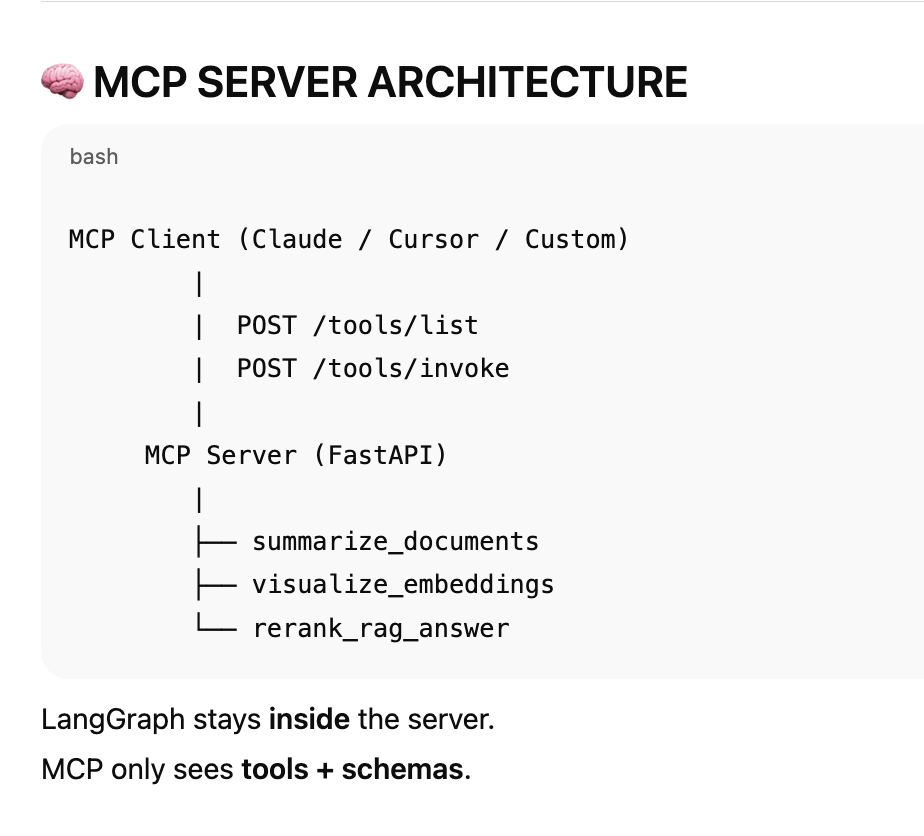

In [26]:
!pip install -U fastapi uvicorn langgraph langchain langchain-openai pydantic


In [27]:
from pydantic import BaseModel
from typing import List

# ---- MCP Tool Input Schemas ----

class SummarizeInput(BaseModel):
    chunks: List[str]

class VisualizeInput(BaseModel):
    chunks: List[str]

class RAGInput(BaseModel):
    query: str
    chunks: List[str]


In [28]:
from openai import OpenAI
import numpy as np
import umap
import faiss
from sklearn.metrics.pairwise import cosine_similarity

client = OpenAI()

def summarize_documents_tool(data: SummarizeInput):
    summaries = []

    for i, chunk in enumerate(data.chunks[:5]):
        resp = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {"role": "system", "content": "Summarize the content."},
                {"role": "user", "content": chunk}
            ]
        )
        summaries.append({
            "chunk_id": i,
            "summary": resp.choices[0].message.content
        })

    return {"summaries": summaries}


In [29]:
def visualize_embeddings_tool(data: VisualizeInput):
    emb = client.embeddings.create(
        model="text-embedding-3-small",
        input=data.chunks
    )

    X = np.array([e.embedding for e in emb.data], dtype="float32")

    reducer = umap.UMAP(n_components=3, metric="cosine", random_state=42)
    coords = reducer.fit_transform(X)

    sim = cosine_similarity(X)

    edges = []
    for i in range(len(data.chunks)):
        nbrs = np.argsort(sim[i])[::-1][1:4]
        for j in nbrs:
            edges.append((i, j))

    return {
        "points": coords.tolist(),
        "edges": edges,
        "texts": data.chunks
    }


In [30]:
def rerank_rag_tool(data: RAGInput):
    emb = client.embeddings.create(
        model="text-embedding-3-small",
        input=data.chunks
    )

    X = np.array([e.embedding for e in emb.data], dtype="float32")

    q_emb = client.embeddings.create(
        model="text-embedding-3-small",
        input=[data.query]
    ).data[0].embedding

    q_emb = np.array(q_emb, dtype="float32")

    index = faiss.IndexFlatIP(X.shape[1])
    index.add(X)

    scores, indices = index.search(np.array([q_emb]), 5)

    context = "\n".join(data.chunks[i] for i in indices[0])

    resp = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": "Answer using only the context."},
            {"role": "user", "content": f"Context:\n{context}\n\nQuestion:\n{data.query}"}
        ]
    )

    return {
        "answer": resp.choices[0].message.content,
        "evidence": indices[0].tolist()
    }


In [31]:
from fastapi import FastAPI
from typing import Dict, Any

app = FastAPI(title="MCP Agentic RAG Server")

TOOLS = {
    "summarize_documents": {
        "description": "Summarize document chunks",
        "input_schema": SummarizeInput,
        "handler": summarize_documents_tool
    },
    "visualize_embeddings": {
        "description": "Create embedding visualization data",
        "input_schema": VisualizeInput,
        "handler": visualize_embeddings_tool
    },
    "rerank_rag_answer": {
        "description": "Answer question using reranked retrieval",
        "input_schema": RAGInput,
        "handler": rerank_rag_tool
    }
}


In [32]:
@app.post("/tools/list")
def list_tools():
    return {
        "tools": [
            {
                "name": name,
                "description": spec["description"],
                "input_schema": spec["input_schema"].model_json_schema()
            }
            for name, spec in TOOLS.items()
        ]
    }


In [33]:
@app.post("/tools/invoke")
def invoke_tool(payload: Dict[str, Any]):
    tool_name = payload.get("tool")
    arguments = payload.get("arguments", {})

    if tool_name not in TOOLS:
        return {"error": f"Unknown tool {tool_name}"}

    schema = TOOLS[tool_name]["input_schema"]
    handler = TOOLS[tool_name]["handler"]

    validated = schema.model_validate(arguments)
    result = handler(validated)

    return {
        "tool": tool_name,
        "result": result
    }


In [38]:
!pip install -U nest_asyncio



In [39]:
import nest_asyncio
nest_asyncio.apply()



In [40]:
import uvicorn
import asyncio

config = uvicorn.Config(
    app,
    host="0.0.0.0",
    port=3333,
    log_level="info"
)

server = uvicorn.Server(config)

# Run inside existing event loop
asyncio.get_event_loop().create_task(server.serve())



<Task pending name='Task-1' coro=<Server.serve() running at /usr/local/lib/python3.12/dist-packages/uvicorn/server.py:69>>

In [42]:
import httpx
import asyncio

async def test_mcp():
    async with httpx.AsyncClient() as client:
        resp = await client.post("http://localhost:3333/tools/list")
        print(resp.json())

asyncio.get_event_loop().run_until_complete(test_mcp())



INFO:     127.0.0.1:43850 - "POST /tools/list HTTP/1.1" 200 OK
{'tools': [{'name': 'summarize_documents', 'description': 'Summarize document chunks', 'input_schema': {'properties': {'chunks': {'items': {'type': 'string'}, 'title': 'Chunks', 'type': 'array'}}, 'required': ['chunks'], 'title': 'SummarizeInput', 'type': 'object'}}, {'name': 'visualize_embeddings', 'description': 'Create embedding visualization data', 'input_schema': {'properties': {'chunks': {'items': {'type': 'string'}, 'title': 'Chunks', 'type': 'array'}}, 'required': ['chunks'], 'title': 'VisualizeInput', 'type': 'object'}}, {'name': 'rerank_rag_answer', 'description': 'Answer question using reranked retrieval', 'input_schema': {'properties': {'query': {'title': 'Query', 'type': 'string'}, 'chunks': {'items': {'type': 'string'}, 'title': 'Chunks', 'type': 'array'}}, 'required': ['query', 'chunks'], 'title': 'RAGInput', 'type': 'object'}}]}


In [43]:
async def invoke_tool():
    async with httpx.AsyncClient() as client:
        resp = await client.post(
            "http://localhost:3333/tools/invoke",
            json={
                "tool": "summarize_documents",
                "arguments": {
                    "chunks": ["This is a test document for MCP."]
                }
            }
        )
        print(resp.json())

asyncio.get_event_loop().run_until_complete(invoke_tool())


INFO:     127.0.0.1:40304 - "POST /tools/invoke HTTP/1.1" 200 OK
{'tool': 'summarize_documents', 'result': {'summaries': [{'chunk_id': 0, 'summary': 'The document is a test document for MCP (which could refer to a specific program or certification). It likely includes information or guidelines related to the testing process, objectives, or requirements. However, no specific details are provided in the summary.'}]}}
